# Dev 04 - Spectral Processing

Using the `toshi` module to read in data and process for spectra

In [232]:
import os
import time
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt

import toshi
import cspec

zmap = cspec.colormap.zmap()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colors', zmap[:, :3], N=len(zmap))

# file = os.path.expanduser('~/Downloads/20200614_150015.256007-87-02.iqData.XXXX.AKITA.dat')
# file = os.path.expanduser('~/Downloads/20200615_010423.194421-8C-02.iqData.XXXX.AKITA.dat')
file = '/Volumes/Transcend/akita/IQ/IQdata/2020.06.14/15/20200614_154942.298346-2F-02.iqData.XXXX.AKITA.dat'
# file = '/Volumes/Transcend/akita/IQ/IQdata/2020.06.14/16/20200614_160000.120540-52-02.iqData.XXXX.AKITA.dat'
# file = '/Volumes/Transcend/akita/IQ/IQdata/2020.06.14/16/20200614_162926.285167-B6-02.iqData.XXXX.AKITA.dat'
# file = '/Volumes/Transcend/akita/IQ/IQdata/2020.06.14/17/20200614_173504.513915-95-02.iqData.XXXX.AKITA.dat'
# file = '/Volumes/Transcend/akita/IQ/IQdata/2020.06.14/21/20200614_210007.277399-4E-02.iqData.XXXX.AKITA.dat'
# file = '/Volumes/Transcend/akita/IQ/IQdata/2020.06.14/23/20200614_230011.592229-E6-02.iqData.XXXX.AKITA.dat'
# file = '/Volumes/Transcend/akita/IQ/IQdata/2020.06.15/00/20200615_000013.702391-B2-02.iqData.XXXX.AKITA.dat'
# file = '/Volumes/Transcend/akita/IQ/IQdata/2020.06.16/08/20200616_080014.361023-2F-02.iqData.XXXX.AKITA.dat'
filesize = os.path.getsize(file)

In [233]:
s = time.time()
ray_pulses, cpi_headers = toshi.read(file)
e = time.time()
print('Data read in {:.2f} s'.format(e - s))

# Go through the pulses for azimuth
a = np.zeros(len(ray_pulses), dtype=np.single)
for k, pulses in enumerate(ray_pulses):
    a[k] = pulses[0].azimuth
    
# Choose ray 2 to whatever that completes the 360-deg coverage
n = np.argmin(np.abs(a[3:] - a[2])) + 1
a = a[2:n+2]

# Subsetting
ray_pulses = ray_pulses[2:n+2]
cpi_headers = cpi_headers[2:n+2]

Data read in 9.58 s


In [234]:
# Dimensions
naz = len(ray_pulses)
ngate_long = ray_pulses[0][0].ngate_long_hi
ngate_short = ray_pulses[0][0].ngate_short_hi
ngate = ngate_long + ngate_short

# Elevation assumed to be flat from the very first pulse
scan_el = ray_pulses[0][0].elevation
scan_time = time.strptime(os.path.basename(file)[:15], '%Y%m%d_%H%M%S')

# Sampling code from the CPI header
fs = 1.0e6 * (1 << cpi_headers[0].fs_code)
dr = 3.0e8 / fs / 2
r = 1.0e-3 * np.arange(0, ngate, dtype=np.single) * dr

In [235]:
# Noise estimate, try azimuth 0, around 20-25 km
ia = np.argmin(np.abs(a[3:] - 0.0)) + 1
ir, er = np.argmin(np.abs(r - 20.0)), np.argmin(np.abs(r - 25.0))
samples = np.zeros((len(ray_pulses[ia]), er-ir), dtype=np.csingle)

# Gather the samples. Ignore phase code since we are only interested in amplitude
for k, pulse in enumerate(ray_pulses[ia]):
    samples[k, :] = pulse.h_long_hi[ir:er]
noise = np.mean(np.abs(samples)) ** 2
print('Noise estimate in 16-bit ADU: {:.4f}'.format(noise))

Noise estimate in 16-bit ADU: 20.7642


In [236]:
s = np.zeros((naz, ngate), dtype=np.single)
v = np.zeros((naz, ngate), dtype=np.single)

# Go through the pulses
a = np.zeros(len(ray_pulses), dtype=np.single)
for k, (pulses, cpi_header) in enumerate(zip(ray_pulses, cpi_headers)):
    p = np.zeros((len(pulses), ngate), dtype=np.csingle)
    a[k] = pulses[0].azimuth
    for j, pulse in enumerate(pulses):
        p[j, ngate_short:] = pulse.h_long_hi * np.exp(-1j * pulse.phase_h_long)
        p[j, :ngate_short] = pulse.h_short_hi * np.exp(-1j * pulse.phase_h_short)
    # pp = pp - np.mean(pp, axis=0)
    pp = p[1:, :] * np.conj(p[:-1, :])
    s[k, :] = np.mean(np.abs(p) ** 2, axis=0)
    v[k, :] = np.angle(np.sum(pp, axis=0))

# Signal
s -= noise
s[s <= 0] = 1.0e-6                                    # Avoid log(0)
snr = 10 * np.log10(s / noise)                        # Signal-to-noise ratio
z = 10 * np.log10(s * (r + 0.5e-3 * dr) ** 2) - 40    # Estimated ZCal = -40 
z[:, :ngate_short] += 30                              # 30-dB on the short waveform, perhaps?

# Thresholding
m = snr < 0
z[m] = np.nan
v[m] = np.nan

Text(0.5, 1.0, '20200614_154942.298346-2F-02.iqData.XXXX.AKITA.dat')

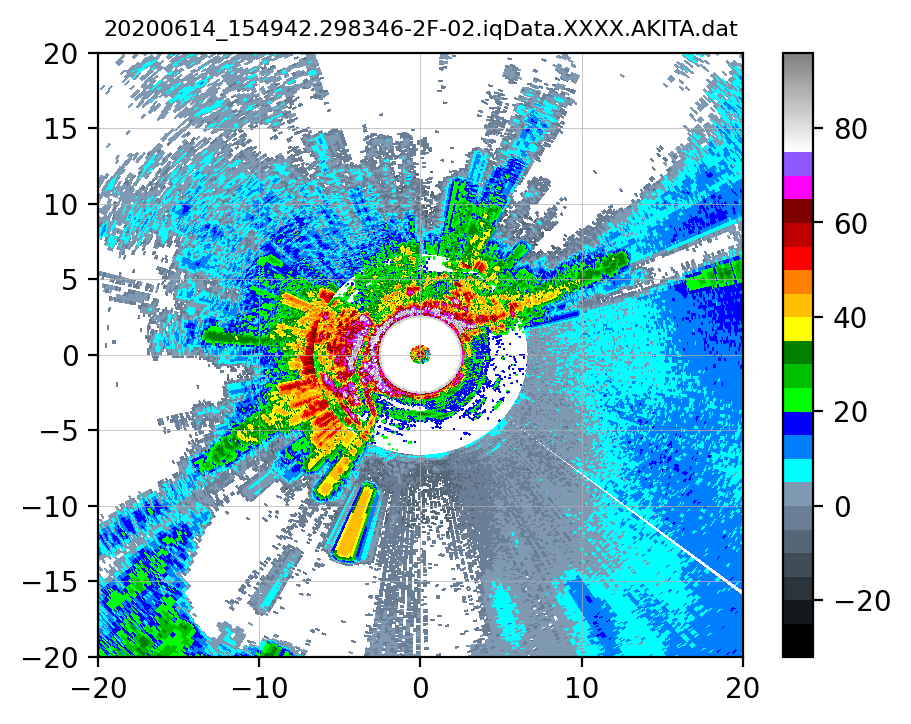

In [237]:
ce = np.cos(np.deg2rad(scan_el))
rr, aa = np.meshgrid(r, np.deg2rad(a))
xx = rr * ce * np.sin(aa)
yy = rr * ce * np.cos(aa)

turbines = toshi.turbine_cells
a_turb = turbines[:, 0] / 180.0 * np.pi
r_turb = turbines[:, 1]
x_turb = r_turb * np.sin(a_turb)
y_turb = r_turb * np.cos(a_turb)

plt.figure(figsize=(5.2, 4), dpi=200)
plt.pcolormesh(xx[:, :500], yy[:, :500], z[:, :500], cmap=cmap)
# plt.plot(x_turb, y_turb, 'xk')
plt.clim((-32, 96))
# plt.xlim((-13, 5))
# plt.ylim((3, 18))
# plt.xlim((-25, 10))
# plt.ylim((0, 35))

plt.xlim((-20, 20))
plt.ylim((-20, 20))

plt.colorbar()
plt.grid(linewidth=0.25)
plt.title(os.path.basename(file), fontsize=8)

In [ ]:
sweep = {
    'longitude': 140.0440751,
    'latitude': 39.7294019,
    'scan_time': scan_time,
    'scan_el': scan_el,
    'aa': aa,
    'rr': rr,
    'z': z,
    'v': v,
    'm': m
}

In [ ]:
cells = cspec.pos2cellid(turbines, a, r)

m = np.zeros(z.shape, dtype=bool)
for c in cells:
    m[c[0], c[1]] = True
m[:, 1:] = np.logical_or(m[:, 1:], m[:, :-1])
m[:, 1:] = np.logical_or(m[:, 1:], m[:, :-1])
m[:, 1:] = np.logical_or(m[:, 1:], m[:, :-1])
m = cspec.dilate(m)
m = cspec.dilate(m)
m[:, 1:] = np.logical_or(m[:, 1:], m[:, :-1])

m1 = cspec.dilate(m)
m2 = cspec.dilate(m1)

tags = cspec.mask2tags(m1)

# Take out the dilated portion
tags[m1 ^ m] = 0

In [ ]:
# Gather the 1st cluster
mask = tags == 1
dmask = cspec.dilate(cspec.dilate(mask))
gmask = dmask ^ mask

# Overide the beginning and end of the cluster
gmask[:, :128] = False
gmask[:, 210:] = False

# Cluster tags in 5-interval
img = 5.0 * (mask + 2.0 * gmask)
img[img < 1] = np.nan

plt.figure(figsize=(5.25, 4), dpi=200)
plt.pcolormesh(xx, yy, img, cmap=cmap)
plt.clim((-32, 96))
plt.xlim((-13, 5))
plt.ylim((3, 18))
plt.colorbar()
plt.grid(linewidth=0.25)

In [ ]:
tt = np.unique(tags)

In [ ]:
dirty_cells = cspec.mask2cells(mask)
clean_cells = cspec.mask2cells(gmask)

In [ ]:
nfft = 128
spec = np.zeros(nfft, dtype=np.single)
for (ia, ir) in clean_cells:
    p = np.zeros(len(ray_pulses[ia]), dtype=np.csingle)
    for k, pulse in enumerate(ray_pulses[ia]):
        p[k] = pulse.h_long_hi[ir - ngate_short]
    spec += np.abs(np.fft.fft(p, nfft))

# m-tap circular averaging
# m = int(nfft * 0.1)
# m = int(np.ceil(nfft * 0.05))
m = 1
filt = spec.copy()
for k in range(1, m):
    filt += np.roll(spec, k)
filt /= np.mean(filt)

In [ ]:
plt.figure(dpi=200)
plt.plot(np.arange(-nfft/2, nfft/2) / nfft * np.pi, 20.0 * np.log10(np.fft.fftshift(filt)))
plt.xlim((-1.6, 1.6))
plt.ylim((-60, 3))
plt.grid(linewidth=0.25)
plt.xlabel('Omega (rad/sample)')
plt.ylabel('Filter Amplitude (dB)')
plt.title('Adaptive Filter Derived from the Clean Cells (m = {})'.format(m))
plt.show()

In [ ]:
sc = s.copy() + noise

for (ia, ir) in dirty_cells:
    p = np.zeros(len(ray_pulses[ia]), dtype=np.csingle)
    for k, pulse in enumerate(ray_pulses[ia]):
        p[k] = pulse.h_long_hi[ir - ngate_short]
    # For sanity check, this should be identical to the original s
    # sc[ia, ir] = np.mean(np.abs(p) ** 2)

    spec = np.abs(np.fft.fft(p, nfft))
    spec *= filt
    sc[ia, ir] = np.sum(spec ** 2 / len(p) / nfft)

# Signal
sc -= noise
sc[sc <= 0] = 1.0e-6                                    # Avoid log(0)

# Reflectivity calculation
snr = 10 * np.log10(sc / noise)                         # Signal-to-noise ratio
zc = 10 * np.log10(sc * (r + 0.5e-3 * dr) ** 2) - 40    # Estimated ZCal = -40 
zc[:, :ngate_short] += 30                               # 30-dB on the short waveform, perhaps?

# Thresholding
m = snr < 0
zc[m] = np.nan

In [ ]:
plt.figure(figsize=(5.25, 4), dpi=200)
plt.pcolormesh(xx[:, :500], yy[:, :500], zc[:, :500], cmap=cmap)
# plt.plot(x_turb, y_turb, '.k')
plt.clim((-32, 96))
plt.xlim((-13, 5))
plt.ylim((3, 18))
plt.colorbar()
plt.grid(linewidth=0.25)

In [181]:
plt.close()